<a href="https://colab.research.google.com/github/Tridude5/ClimateRiskCoach/blob/main/Climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MScFE Capstone Project**
## Student Group: **11191**

### Members:
1. **Miklos Lammel**
2. **Jack Slavinskas**
3. **Cathal de Lacy**

## **Install and then import python packages**

In [6]:
# installing the required libraries
!pip install fredapi

# importing the required libraries

import io
import json
import requests
from datetime import date

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from fredapi import Fred
import yfinance as yf

from scipy.signal import savgol_filter

import warnings
warnings.filterwarnings('ignore')

## **Data import**
Import, structure and graph the climate related indicator variable



- ESG Index (Environmental, Social, Governance): Monthly index data, can be sourced from providers like Indxx.com which is a paid, proprietary solution. As a proxy we can use ETFs. It captures corporate environmental and social risk management and sustainability practices.
- CPU Index (Climate Policy Uncertainty): Monthly data, available from the policyuncertainty.com website. Measures unpredictability in government climate-related actions and regulation.
- TRI (Transition Risk Index): Daily index, tracks risks from regulatory change, technology shifts, and market transformation related to moving toward a low-carbon economy. Data available from policyuncertainty.com and referenced datasets.
- PRI (Physical Risk Index): Daily index, measures vulnerability to extreme weather events and long-term physical changes (rising temperature, sea level, droughts, hurricanes, etc.). Also found on policyuncertainty.com and climate risk data repositories such as Guo et al. 2024.
- EPU Index (Economic Policy Uncertainty): Monthly data, standard financial uncertainty measure, available from policyuncertainty.com.



The ESG indices are usually proprietary and paid. Indxx.com has a nice set of ESG indices which was used by Maria Ghani in her work "Forecasting Climate-Sensitive Industries' Volatility"

Possible ESG indices / proxies accessible via yfinance

These aren't “ESG index series” per se, but ETFs whose performance roughly tracks ESG/ESG-screened equity portfolios:

ESGV — Vanguard ESG U.S. Stock ETF (US)
Yahoo Finance

ESGU — iShares ESG Aware MSCI USA ETF
Yahoo Finance

ESGD — iShares ESG Aware MSCI EAFE ETF
Yahoo Finance

SUSA — iShares ESG Optimized MSCI USA ETF
Yahoo Finance

USXF — iShares ESG Advanced MSCI USA ETF
Yahoo Finance

EEWD.L — iShares MSCI World ESG Enhanced CTB UCITS ETF (in London listing)
Yahoo Finance

These ETFs can give a time series of returns or price levels that approximate ESG-indexed performance in their respective universes.

Additionally, via yfinance, tickers sometimes have a .sustainability attribute containing ESG/risk scores (for individual companies)

## Climate Policy Uncertainty Index (CPU)

Start date: 1987-04-30
End date: 2025-06-30


,Global_CPU_Index
date,
1987-04-30,43.589069
1987-05-31,41.862022
1987-06-30,71.135203
1987-07-31,53.756704
1987-08-31,60.615545


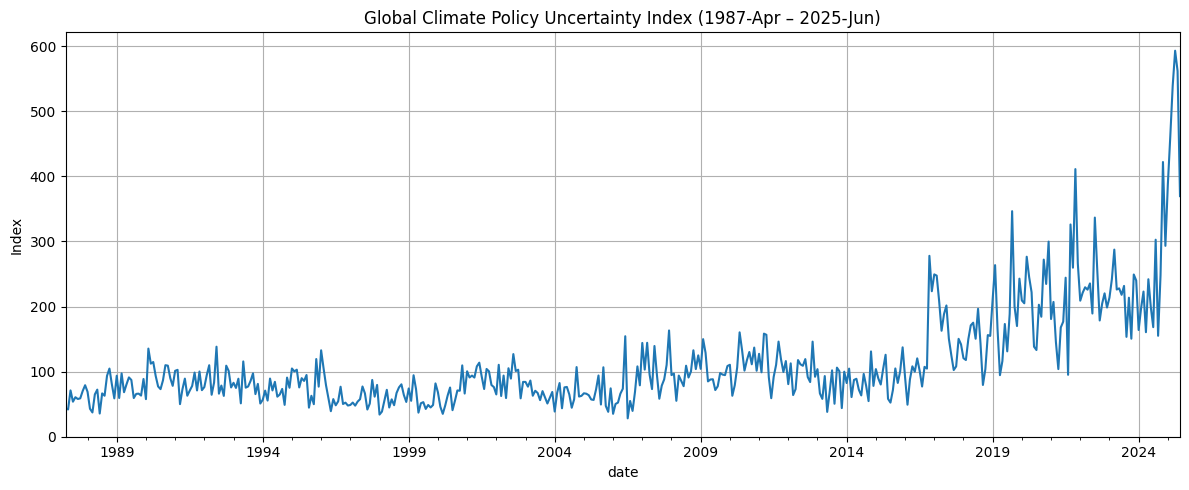

In [4]:
# downloading the dataset (excel)
url = "https://www.policyuncertainty.com/media/CPU%20index.csv"

# Header is on the 5th line (0-based index -> header=4)
df = pd.read_csv(url, header=4, encoding="cp1252")

# Normalize column names
df.columns = [c.strip().lower() for c in df.columns]

# Parse dates like "Apr-87" -> monthly timestamps (use month end for nicer plots)
df["date"] = pd.to_datetime(df["date"], format="%b-%y", errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date")
df["date"] = df["date"].dt.to_period("M").dt.to_timestamp("M")

# Use the global CPU index column from this file
cpu = df[["date", "cpu_index"]].rename(columns={"cpu_index": "Global_CPU_Index"}).set_index("date")

# Period of the dataset
date_from = cpu.first_valid_index()
date_to = cpu.last_valid_index()
print("Start date:", date_from.date())
print("End date:", date_to.date())

# Quick peek
display(cpu.head())

# Plot
ax = cpu.plot(
    title=f"Global Climate Policy Uncertainty Index ({date_from:%Y-%b} – {date_to:%Y-%b})",
    figsize=(12, 5),
    legend=False,
)
ax.set_ylabel("Index")
ax.grid(True)
plt.tight_layout()
plt.show()

### Interpolating to daily frequency

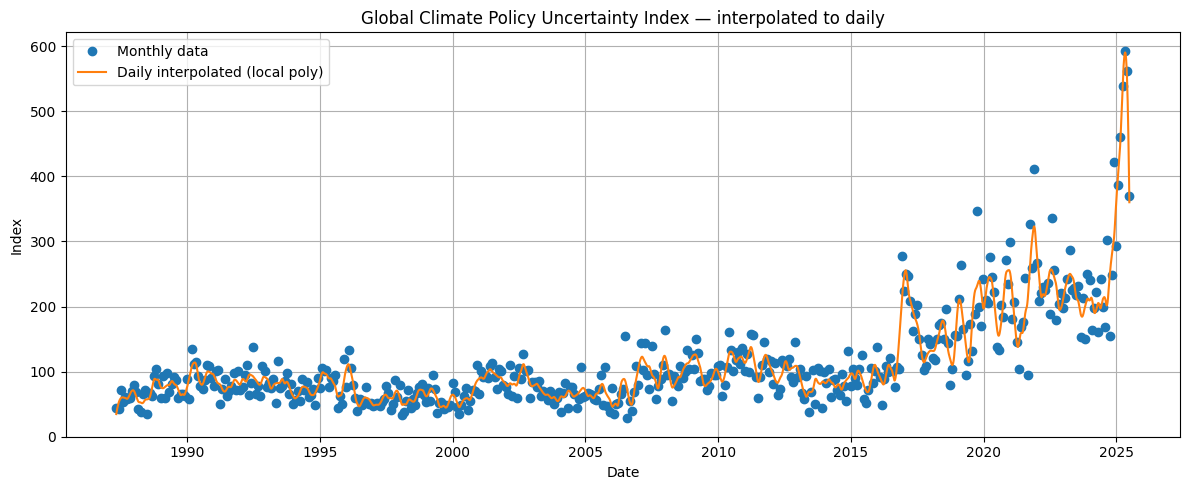

In [7]:

# Start from your monthly CPU data
url = "https://www.policyuncertainty.com/media/CPU%20index.csv"
df = pd.read_csv(url, header=4, encoding="cp1252")
df.columns = [c.strip().lower() for c in df.columns]
df["date"] = pd.to_datetime(df["date"], format="%b-%y", errors="coerce")
df = df.dropna(subset=["date"]).sort_values("date")
df["date"] = df["date"].dt.to_period("M").dt.to_timestamp("M")
cpu = df.set_index("date")[["cpu_index"]].rename(columns={"cpu_index": "Global_CPU_Index"})

# Step 1: reindex to daily
daily_index = pd.date_range(cpu.index.min(), cpu.index.max(), freq="D")
cpu_daily = cpu.reindex(daily_index)

# Step 2: interpolate linearly first (to fill NaNs)
cpu_daily["Global_CPU_Index"] = cpu_daily["Global_CPU_Index"].interpolate(method="time")

# Step 3: apply Savitzky–Golay filter (local polynomial smoothing)
# window_length = 7 months ~ 7*30 days, but must be odd integer
window_days = 7*30 + 1
poly_order = 3  # cubic local fit
cpu_daily["Global_CPU_Smoothed"] = savgol_filter(
    cpu_daily["Global_CPU_Index"],
    window_length=window_days,
    polyorder=poly_order,
    mode="interp"
)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(cpu.index, cpu["Global_CPU_Index"], "o", label="Monthly data")
plt.plot(cpu_daily.index, cpu_daily["Global_CPU_Smoothed"], "-", label="Daily interpolated (local poly)")
plt.title("Global Climate Policy Uncertainty Index — interpolated to daily")
plt.xlabel("Date")
plt.ylabel("Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


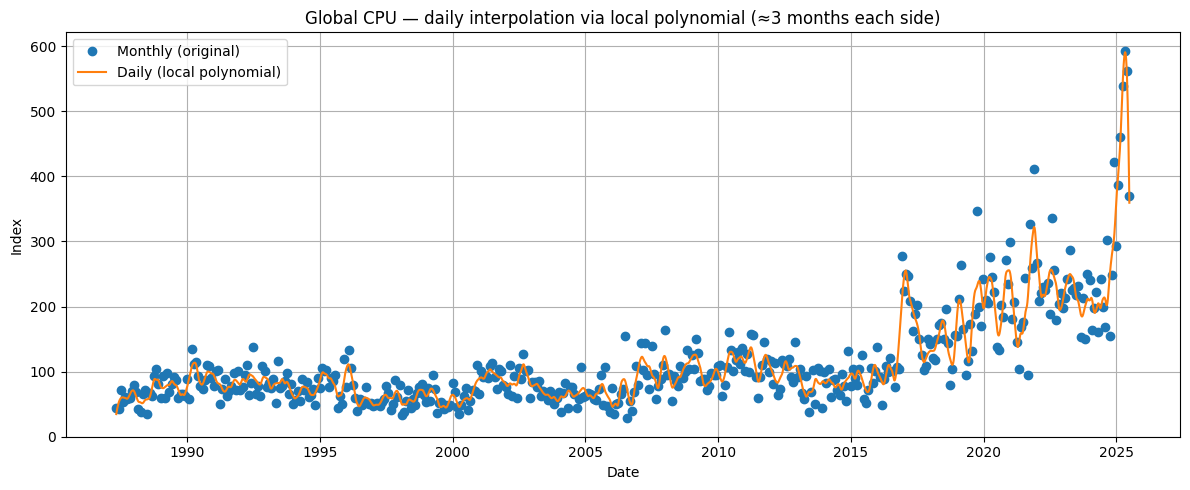

2015-03-14 → 92.408


In [8]:
# ---- 1) work on a copy so the original `cpu` is untouched ----
cpu_daily = cpu.copy(deep=True)

# identify the value column
value_col = cpu_daily.columns[0]

# ---- 2) upsample to daily and 3) interpolate by time ----
daily_idx = pd.date_range(cpu_daily.index.min(), cpu_daily.index.max(), freq="D")
cpu_daily = cpu_daily.reindex(daily_idx)
cpu_daily[value_col] = cpu_daily[value_col].interpolate(method="time")

# ---- 4) local polynomial smoothing (3 months before + 3 months after) ----
# Use a ~7-month window in days; Savitzky–Golay requires an odd window length
approx_days_per_month = 30.44
window_days = int(round(7 * approx_days_per_month))
if window_days % 2 == 0:
    window_days += 1
# ensure window < series length and >= polyorder+2
poly_order = 3
window_days = max(poly_order + 2 + (1 - (poly_order + 2) % 2), min(window_days, len(cpu_daily) - (1 - len(cpu_daily) % 2)))
if window_days >= len(cpu_daily):
    window_days = len(cpu_daily) - 1 if len(cpu_daily) % 2 == 0 else len(cpu_daily)

cpu_daily["Interpolated_LocalPoly"] = savgol_filter(
    cpu_daily[value_col].to_numpy(),
    window_length=window_days,
    polyorder=poly_order,
    mode="interp"
)

# ---- 5) plot monthly points vs daily curve ----
plt.figure(figsize=(12, 5))
plt.plot(cpu.index, cpu[value_col], "o", label="Monthly (original)")
plt.plot(cpu_daily.index, cpu_daily["Interpolated_LocalPoly"], "-", label="Daily (local polynomial)")
plt.title("Global CPU — daily interpolation via local polynomial (≈3 months each side)")
plt.xlabel("Date"); plt.ylabel("Index"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

# Example: value on a specific day
example_day = "2015-03-14"
print(f"{example_day} → {cpu_daily.loc[example_day, 'Interpolated_LocalPoly']:.3f}")

# Other possible related dataseries

### **Get geopolitcal data (GPR, EUI)**

Start date: 1985-01-01 00:00:00
End date: 2025-06-01 00:00:00


,GPR
month,
1985-01-01,102.173378
1985-02-01,117.102020
1985-03-01,124.778152
1985-04-01,87.929001
1985-05-01,103.262848


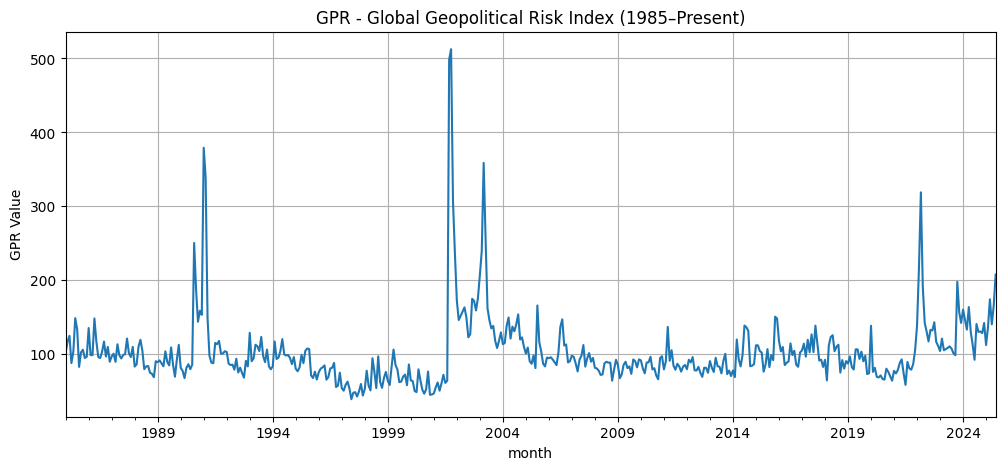

In [ ]:
# getting Geopolitical Risk Index - GPR (1985 - 2025)

# downloading the dataset
url = "https://www.matteoiacoviello.com/gpr_files/data_gpr_export.xls"
df = pd.read_excel(url) # top row is month and GPR
df['month'] = pd.to_datetime(df['month'], format='%d/%m/%Y')
df.set_index('month', inplace=True)
gpr = df[['GPR']]
gpr = gpr[gpr.index >= '1985-01-01']

date_from = gpr.first_valid_index()
date_to = gpr.last_valid_index()
print("Start date:", date_from)
print("End date:", date_to)
display(gpr.head())

# plotting the GPR series
gpr.plot(title='GPR - Global Geopolitical Risk Index (1985–Present)', figsize=(12, 5), legend=False)
plt.ylabel('GPR Value')
plt.grid(True)
plt.show()

Start date: 1996-01-01
End date: 2023-11-01


,Energy_Uncertainty_Index
Date,
1996-01-01,0.358232
1996-02-01,0.373172
1996-03-01,0.203098
1996-04-01,0.317945
1996-05-01,0.711228


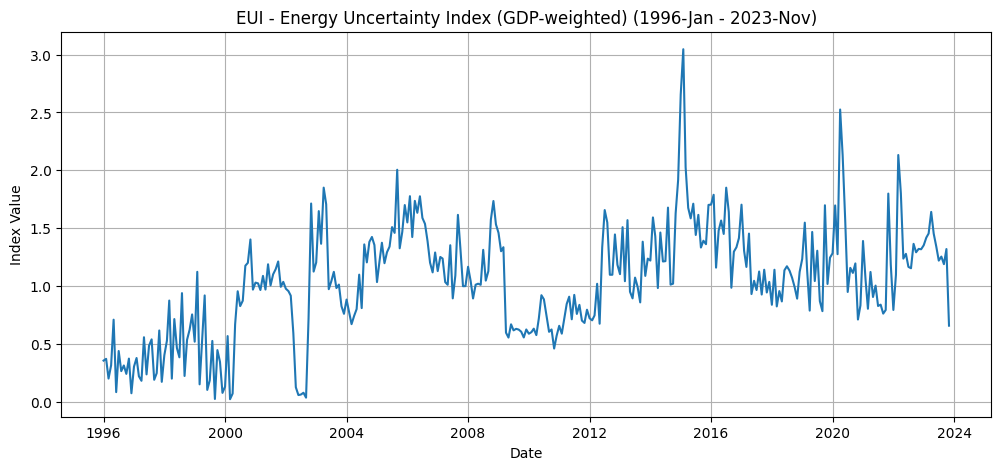

In [ ]:
# getting Energy Uncertainty Risk Index - EUI (1996-2023 monthly data)


# downloading the dataset (excel)
url = "https://www.policyuncertainty.com/media/Energy-Related%20Uncertainty%20Indexes.xlsx"
sheet_name = "Global Average EUI Indexes"

df = pd.read_excel(url, sheet_name=sheet_name, header=2, converters={'Date': str})
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%d-%m %H:%M:%S', errors='coerce')
df['Date'] = df['Date'].dt.date
df.set_index('Date', inplace=True)

# extracting the energy index
energy_index = df[['global_EUI_GDP_weighted']]
energy_index.rename(columns={'global_EUI_GDP_weighted': 'Energy_Uncertainty_Index'}, inplace=True)

# perid of the downloaded dataset
date_from = energy_index.first_valid_index()
date_to = energy_index.last_valid_index()
print("Start date:", date_from)
print("End date:", date_to)
display(energy_index.head())

# plotting the EUI series
energy_index.plot(title=f"EUI - Energy Uncertainty Index (GDP-weighted) ({date_from.strftime('%Y-%b')} - {date_to.strftime('%Y-%b')})", figsize=(12, 5), legend=False)
plt.ylabel('Index Value')
plt.grid(True)
plt.show()

### **Get FRED data (CPI, GDP)**

CPI (Consumer Price Index)


,US CPI
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


GDP (Gross Domestic Product)


,US GDP Growth Rate
1947-04-01,-1.0
1947-07-01,-0.8
1947-10-01,6.4
1948-01-01,6.2
1948-04-01,6.8


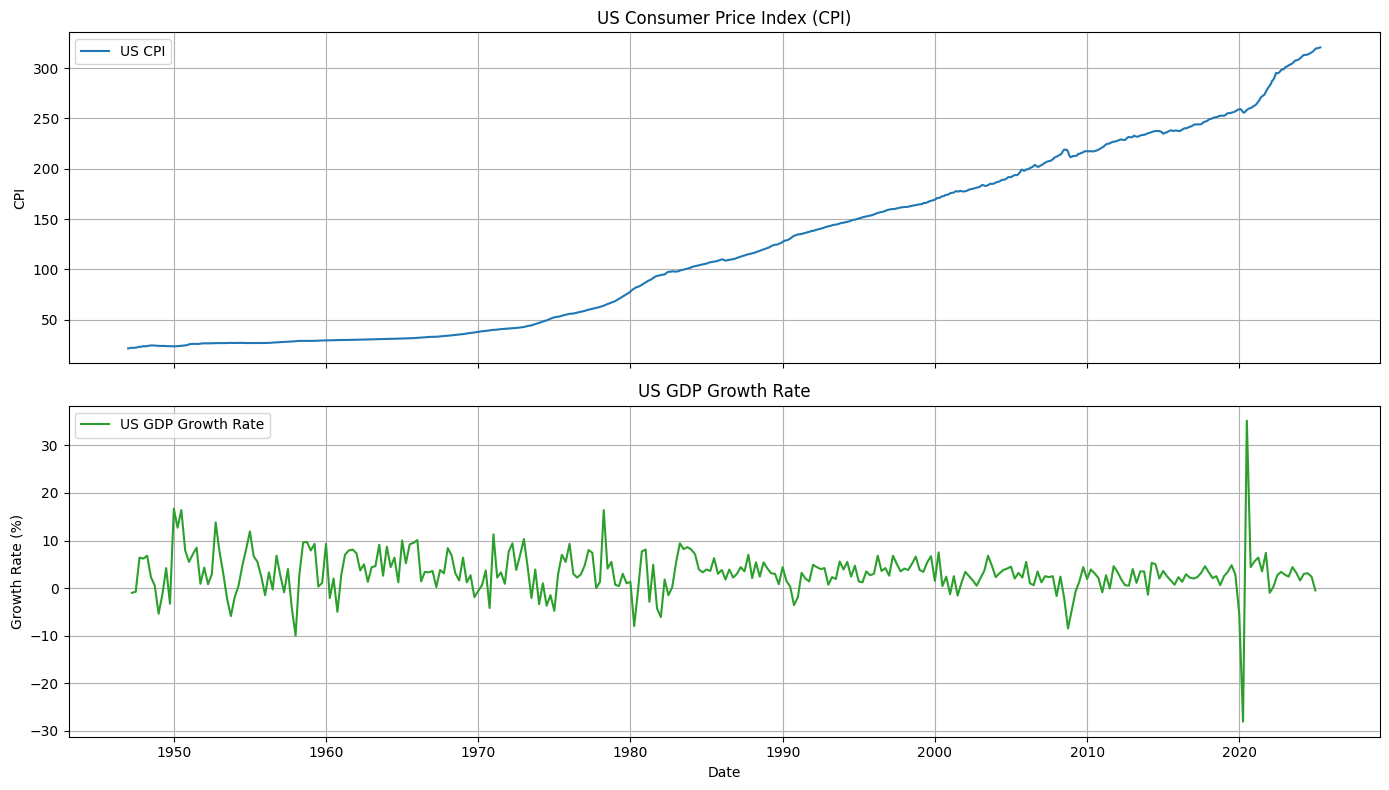

In [ ]:
FRED_API_KEY = '1eca31140fb3700173f5c8b43fecbf97'
fred = Fred(api_key=FRED_API_KEY)

# retrieving US CPI (Consumer Price Index) and US GDP (Gross Domestic Product) data
cpi = fred.get_series('CPIAUCSL')
gdp = fred.get_series('A191RL1Q225SBEA')
cpi.name = 'US CPI'
gdp.name = 'US GDP Growth Rate'

print("CPI (Consumer Price Index)")
display(cpi.head())

print("GDP (Gross Domestic Product)")
display(gdp.head())

# plotting US CPI and GDP series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(cpi, label=cpi.name, color='tab:blue')
ax1.set_title('US Consumer Price Index (CPI)')
ax1.set_ylabel('CPI')
ax1.grid(True)
ax1.legend()

ax2.plot(gdp, label=gdp.name, color='tab:green')
ax2.set_title('US GDP Growth Rate')
ax2.set_xlabel('Date')
ax2.set_ylabel('Growth Rate (%)')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

### **Get VIX index**

,VIX_Close
Date,
1996-01-02,12.19
1996-01-03,12.10
1996-01-04,13.78
1996-01-05,13.58
1996-01-08,13.11


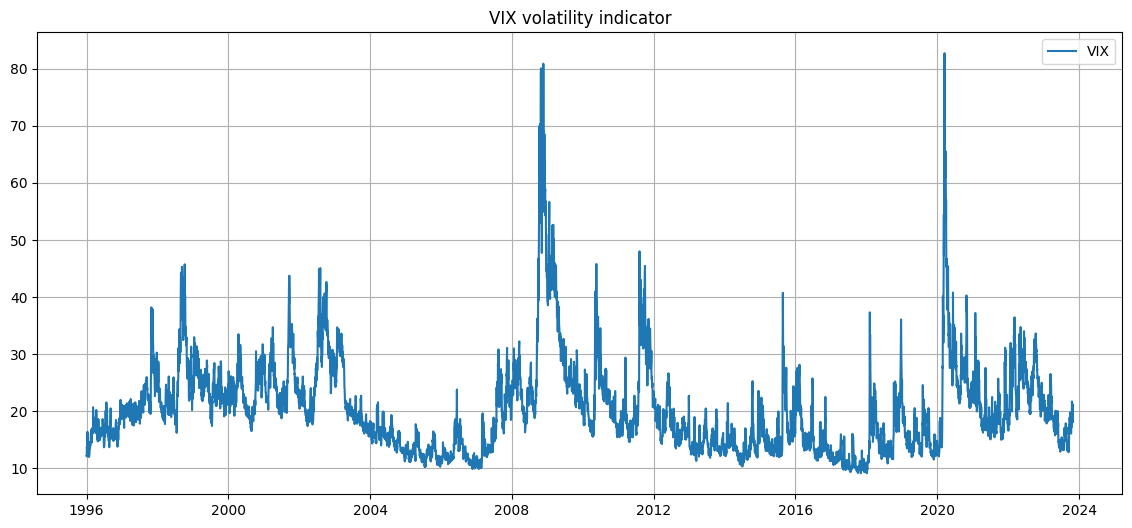

In [ ]:
# downloading VIX index from Yahoo finance
vix = yf.download('^VIX', start='1996-01-01', end='2023-11-01', progress=False, auto_adjust = True)
vix = vix[('Close', '^VIX')].rename('VIX_Close').to_frame()
display(vix.head())

# plotting the VIX series
plt.figure(figsize=(14, 6))
plt.title('VIX volatility indicator')
plt.plot(vix['VIX_Close'], label='VIX')
plt.legend()
plt.grid(True)
plt.show()

### **Get US Dollar Index (DXY)**

,DXY_Close
Date,
1996-01-01,84.760002
1996-01-02,84.690002
1996-01-03,85.110001
1996-01-04,85.220001
1996-01-05,85.059998


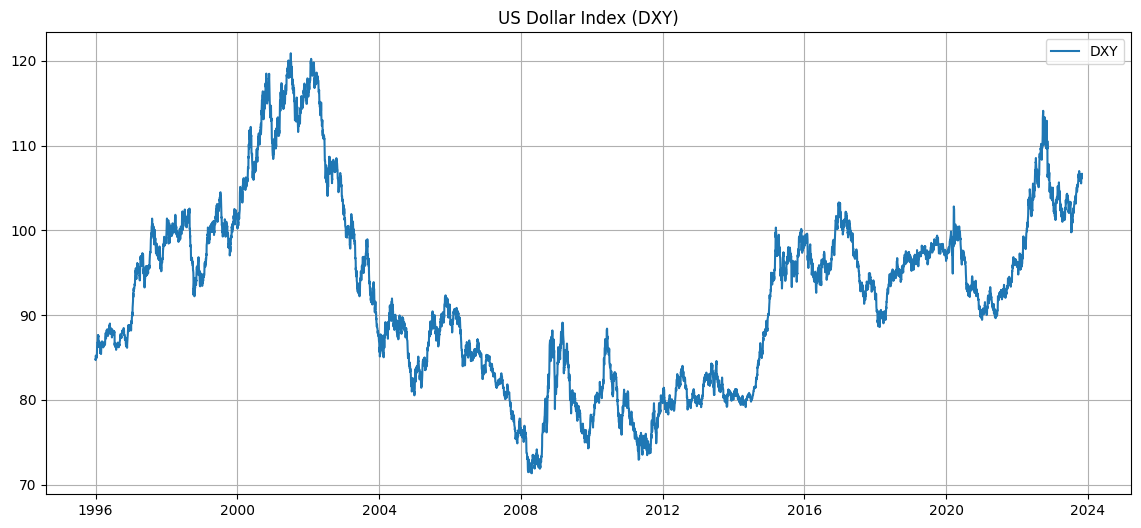

In [ ]:
# downloading DXY (US Dollar Index) from Yahoo finance
dxy = yf.download('DX-Y.NYB', start='1996-01-01', end='2023-11-01', progress=False, auto_adjust=True)
dxy = dxy[('Close', 'DX-Y.NYB')].rename('DXY_Close').to_frame()
display(dxy.head())

# plotting the DXY series
plt.figure(figsize=(14, 6))
plt.title('US Dollar Index (DXY)')
plt.plot(dxy['DXY_Close'], label='DXY')
plt.legend()
plt.grid(True)
plt.show()


Refinery Utilization Rate (FRED)
Start date: 1991-07-01 00:00:00
End date: 2025-05-01 00:00:00


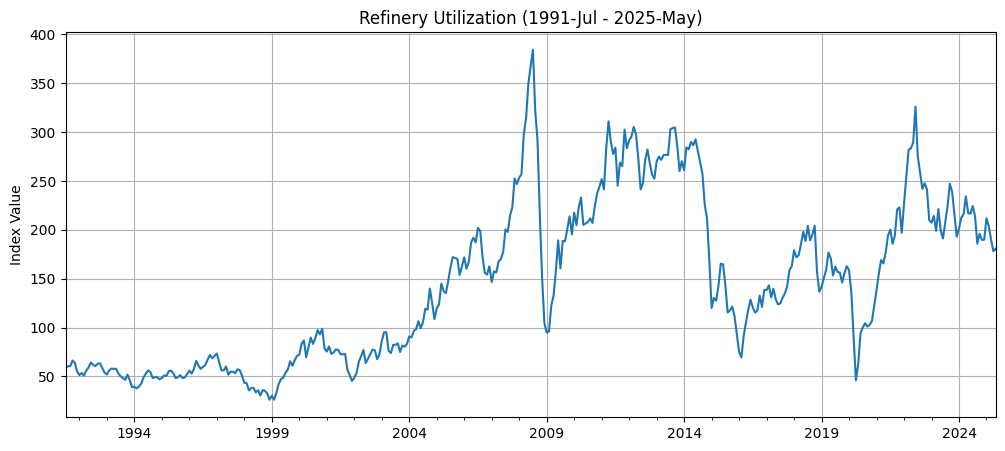

In [ ]:
FRED_API_KEY = '1eca31140fb3700173f5c8b43fecbf97'
fred = Fred(api_key=FRED_API_KEY)

rur = fred.get_series('WPU056101')
rur.name = 'Refinery Utilization rate'
print("Refinery Utilization Rate (FRED)")

# perid of the downloaded dataset
date_from = rur.first_valid_index()
date_to = rur.last_valid_index()
print("Start date:", date_from)
print("End date:", date_to)

# plotting the RUR series
rur.plot(title=f"Refinery Utilization ({date_from.strftime('%Y-%b')} - {date_to.strftime('%Y-%b')})", figsize=(12, 5), legend=False)
plt.ylabel('Index Value')
plt.grid(True)
plt.show()